In [ ]:
!pip install gdown
!pip install h5py
import gdown
import gdown
import zipfile
import os
url = 'https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr'
output_path = 'large_file.hdf5'
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr
From (redirected): https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr&confirm=t&uuid=cc2d4e26-6428-4dfd-aac7-16a4971961f2
To: /kaggle/working/large_file.hdf5
100%|██████████| 701M/701M [00:02<00:00, 268MB/s]  


'large_file.hdf5'

In [ ]:
import h5py

def print_hdf5_file_contents(file, indent=0):
    for key in file.keys():
        if isinstance(file[key], h5py.Group):
            print(" " * indent + f"Group: {key}")
            print_hdf5_file_contents(file[key], indent + 4)
        elif isinstance(file[key], h5py.Dataset):
            print(" " * indent + f"Dataset: {key} (Shape: {file[key].shape}, Dtype: {file[key].dtype})")
        else:
            print(" " * indent + f"Attribute: {key} = {file[key].value}")

with h5py.File('large_file.hdf5', 'r') as file:
    print_hdf5_file_contents(file)

Dataset: X_jets (Shape: (139306, 125, 125, 3), Dtype: float32)
Dataset: m0 (Shape: (139306,), Dtype: float32)
Dataset: pt (Shape: (139306,), Dtype: float32)
Dataset: y (Shape: (139306,), Dtype: float32)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
train_imgs = None
test_imgs = None
with h5py.File('large_file.hdf5', 'r') as file:
    train_imgs = np.array(file['X_jets'][:4096])
    test_imgs = np.array(file['X_jets'][4096:4096+1024])
    print(train_imgs[0].shape)

(125, 125, 3)


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Converting all 3 features to 3 channels image

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
class Data(torch.utils.data.Dataset):
    def __init__(self,imgs):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.,0.,0.],[1.,1.,1.]),
        ])
        self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self,idx):
        img = self.transform(self.imgs[idx])
        img2 = torch.zeros((3,128,128)).to(img.dtype)
        img2[:,:125,:125] = img
        return img2

train_loader = torch.utils.data.DataLoader(Data(train_imgs), batch_size=64)
val_loader = torch.utils.data.DataLoader(Data(test_imgs), batch_size=64)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
for imgs in val_loader:
    print(imgs.shape,imgs.dtype)
    break

torch.Size([64, 3, 128, 128]) torch.float32


## Variational Autoencoder with Reparametrization trick

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Increased channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Increased channels
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Increased channels
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, latent_dim * 2),
            nn.BatchNorm1d(latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 16 * 16),
            nn.BatchNorm1d(256 * 16 * 16),
            nn.Unflatten(1, (256, 16, 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        mu, log_var = torch.chunk(z, 2, dim=1)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)
    ## to ensure gradient flow
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

latent_dim = 64
learning_rate = 0.1
num_epochs = 50
batch_size = 64

model = VAE(latent_dim).to(device)
reconstruction_loss = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

prev_loss = float('inf')
best_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Validation loop
    model.eval()
    val_loader = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (val)')
    for batch_idx, data in enumerate(val_loader):
        data = data.to(device)
        with torch.no_grad():
            recon_batch, mu, log_var = model(data)
            loss = reconstruction_loss(recon_batch, data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())##kl divergence loss
            loss += 0.5*kl_divergence
            val_loss += loss.item()
            val_loader.set_postfix(val_loss=val_loss / ((batch_idx + 1)))
        del data

    if val_loss / len(val_loader) >= prev_loss:
        learning_rate *= 0.1
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Changing learning rate to {learning_rate}")
    prev_loss = val_loss/(len(val_loader))

    # Training loop
    model.train()
    train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (train)')
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = reconstruction_loss(recon_batch, data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss += 0.5*kl_divergence
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loader.set_postfix(train_loss=train_loss / ((batch_idx + 1)))
    del data

    if val_loss<best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(),"model.pth")
        print("saved model to model.pth")

Epoch 1/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.46it/s, train_loss=1.75e+4]


saved model to model.pth


Epoch 2/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.26it/s, train_loss=66.1]


saved model to model.pth


Epoch 3/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.43it/s, train_loss=47.5]


saved model to model.pth


Epoch 4/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.50it/s, train_loss=40.8]


saved model to model.pth


Epoch 5/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.25it/s, train_loss=36.7]


saved model to model.pth


Epoch 6/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.62it/s, train_loss=33.7]


saved model to model.pth


Epoch 7/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.49it/s, train_loss=31.4]


saved model to model.pth


Epoch 8/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.74it/s, train_loss=29.6]


saved model to model.pth


Epoch 9/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.56it/s, train_loss=28.2]


saved model to model.pth


Epoch 10/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.37it/s, train_loss=27.2]


saved model to model.pth


Epoch 11/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.44it/s, train_loss=26.4]


saved model to model.pth


Epoch 12/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.79it/s, train_loss=25.8]


saved model to model.pth


Epoch 13/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.44it/s, train_loss=25.3]


saved model to model.pth


Epoch 14/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.48it/s, train_loss=24.9]


saved model to model.pth


Epoch 15/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.64it/s, train_loss=24.6]


saved model to model.pth


Epoch 16/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.62it/s, train_loss=24.2]


saved model to model.pth


Epoch 17/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.47it/s, train_loss=24]  


saved model to model.pth


Epoch 18/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.23it/s, train_loss=23.7]


saved model to model.pth


Epoch 19/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.40it/s, train_loss=23.4]


saved model to model.pth


Epoch 20/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.67it/s, train_loss=23.2]


saved model to model.pth


Epoch 21/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.58it/s, train_loss=22.9]


saved model to model.pth


Epoch 22/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.46it/s, train_loss=22.7]


saved model to model.pth


Epoch 23/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.58it/s, train_loss=22.4]


saved model to model.pth


Epoch 24/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.65it/s, train_loss=22.2]


saved model to model.pth


Epoch 25/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.68it/s, train_loss=21.9]


saved model to model.pth


Epoch 26/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.32it/s, train_loss=21.7]


saved model to model.pth


Epoch 27/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.22it/s, train_loss=21.5]


saved model to model.pth


Epoch 28/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.61it/s, train_loss=21.3]


saved model to model.pth


Epoch 29/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.59it/s, train_loss=21.1]


saved model to model.pth


Epoch 30/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.73it/s, train_loss=20.9]


saved model to model.pth


Epoch 31/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.57it/s, train_loss=20.7]


saved model to model.pth


Epoch 32/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.63it/s, train_loss=20.6]


saved model to model.pth


Epoch 33/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.57it/s, train_loss=20.5]


saved model to model.pth


Epoch 34/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.74it/s, train_loss=20.2]


saved model to model.pth


Epoch 35/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.59it/s, train_loss=20.1]


saved model to model.pth


Epoch 36/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.15it/s, train_loss=19.9]


saved model to model.pth


Epoch 37/50 (train): 100%|██████████| 64/64 [00:03<00:00, 19.28it/s, train_loss=19.8]


saved model to model.pth


Epoch 38/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.49it/s, train_loss=19.7]


saved model to model.pth


Epoch 39/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.34it/s, train_loss=19.5]


saved model to model.pth


Epoch 40/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.19it/s, train_loss=19.4]


saved model to model.pth


Epoch 41/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.50it/s, train_loss=19.3]


saved model to model.pth


Epoch 42/50 (val): 100%|██████████| 16/16 [00:00<00:00, 36.80it/s, val_loss=15.8]


Changing learning rate to 0.010000000000000002


Epoch 43/50 (train): 100%|██████████| 64/64 [00:03<00:00, 19.89it/s, train_loss=17.8]


saved model to model.pth


Epoch 44/50 (train): 100%|██████████| 64/64 [00:03<00:00, 19.86it/s, train_loss=17.7]


saved model to model.pth


Epoch 45/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.65it/s, train_loss=17.7]


saved model to model.pth


Epoch 46/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.70it/s, train_loss=17.7]


saved model to model.pth


Epoch 47/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.74it/s, train_loss=17.7]


saved model to model.pth


Epoch 48/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.26it/s, train_loss=17.7]


saved model to model.pth


Epoch 49/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.38it/s, train_loss=17.6]


saved model to model.pth


Epoch 50/50 (train): 100%|██████████| 64/64 [00:03<00:00, 20.50it/s, train_loss=17.6]


saved model to model.pth


In [ ]:
try:
    del model
    print("deleted model")
except:
    None
torch.cuda.empty_cache()

deleted model


## comparing all three features

tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)


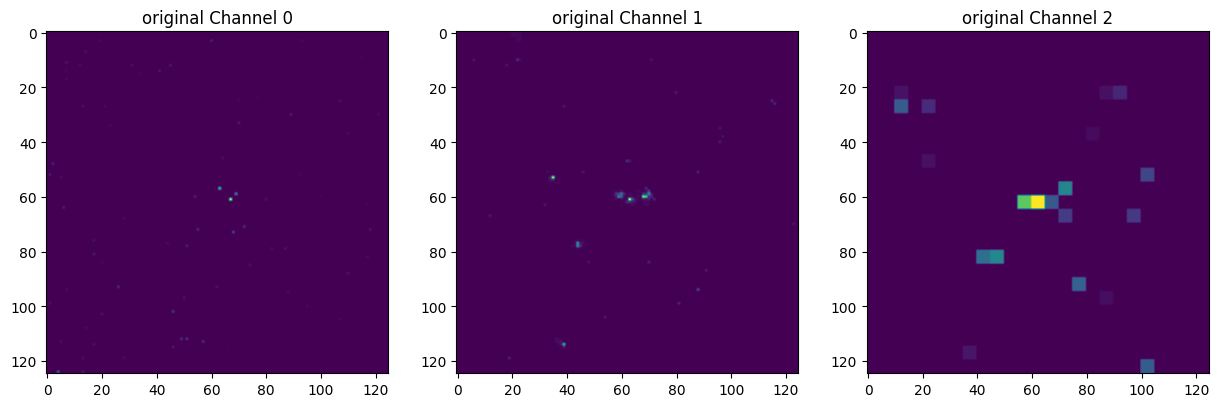

In [ ]:
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load("model.pth"))
import random
model.eval()
r = random.randint(0,500)
dataset = Data(test_imgs)
imgorig = dataset[r]
imgrecons = model(imgorig.unsqueeze(0).to(device))[0]
recon_batch, mu, log_var = model(imgorig.unsqueeze(0).to(device))
loss = reconstruction_loss(recon_batch, imgorig.unsqueeze(0).to(device))
print(loss)
kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
loss += kl_divergence
print(loss)
# print(np.array(imgrecons.cpu()).shape)
pltorig = imgorig.permute(1,2,0).cpu().numpy()[:125,:125,:]
pltrecons = imgrecons.permute(0,2,3,1).detach().cpu().numpy()[0][:125,:125,:]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(pltorig[:,:,0])
axs[0].set_title('original Channel 0')

axs[1].imshow(pltorig[:,:,1])
axs[1].set_title('original Channel 1')

axs[2].imshow(pltorig[:,:,2])
axs[2].set_title('original Channel 2')
plt.show()

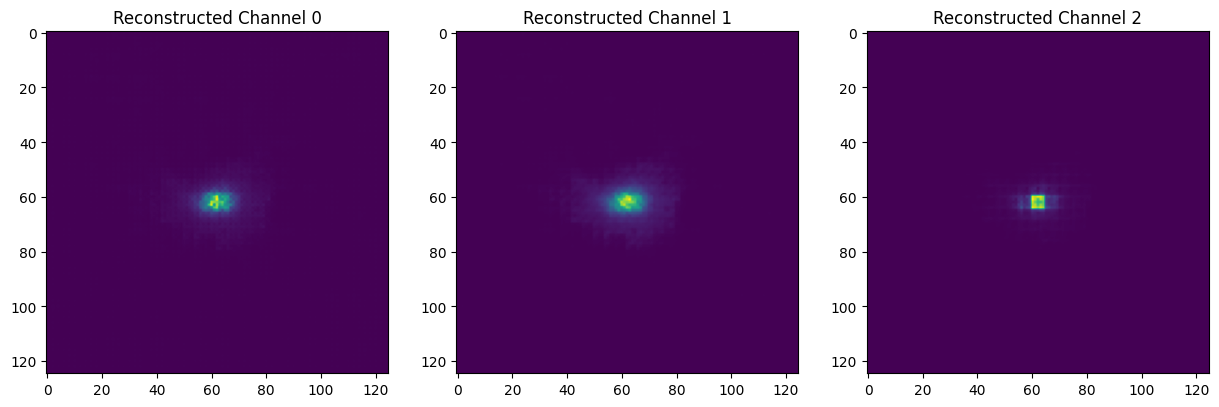

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(pltrecons[:,:,0])
axs[0].set_title('Reconstructed Channel 0')

axs[1].imshow(pltrecons[:,:,1])
axs[1].set_title('Reconstructed Channel 1')

axs[2].imshow(pltrecons[:,:,2])
axs[2].set_title('Reconstructed Channel 2')
plt.show()